# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

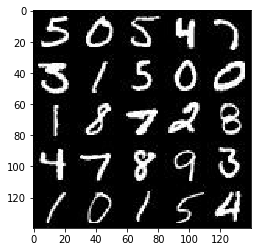

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

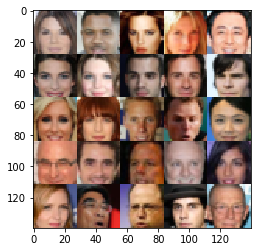

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learnin_rate', shape=())
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 1st conv layer
        # Image Layer is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 2nd conv layer
        # Image Layer is 14 x 14 x 64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, trainable=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop_out1 = tf.nn.dropout(relu2, keep_prob=prob)
        
        # 3rd conv layer
        # Image layer is 7 x 7 x 128
        x3 = tf.layers.conv2d(drop_out1, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, trainable=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop_out2 = tf.nn.dropout(relu3, keep_prob=prob)
        
        # Output connected layer
        # 4 x 4 x 256
        flat = tf.reshape(drop_out2, shape=(-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, prob=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        print('Training Value: ', is_train)
        # Input fully connected layer
        # 7 x 7 x 128
        x1 = tf.layers.dense(z, 7 * 7 * 128)
        #Reshape to start the convolutional stack
        reshapex1 = tf.reshape(x1, (-1, 7, 7, 128))
        # Normalize
        bn = tf.layers.batch_normalization(reshapex1, training=is_train)
        conv1 = tf.maximum(alpha * bn, bn)

        # 14 x 14 x 64
        x2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x2, training=is_train)
        conv2 = tf.maximum(alpha * bn1, bn1)
        dropOut1 = tf.nn.dropout(conv2, keep_prob=prob)

        # 28 x 28 x 128
#         x3 = tf.layers.conv2d_transpose(dropOut1, 32, 5, strides=2, padding='same')
#         bn2 = tf.layers.batch_normalization(x3, training=is_train)
#         conv3 = tf.maximum(alpha * bn2, bn2)
#         dropOut2 = tf.nn.dropout(conv3, keep_prob=prob)

        logits = tf.layers.conv2d_transpose(dropOut1, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x 3

        out = tf.tanh(logits)
        print(out)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Training Value:  True
Tensor("Tanh:0", shape=(?, 28, 28, 5), dtype=float32)
Training Value:  False
Tensor("Tanh_1:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator Model
    generator_model = generator(input_z, out_channel_dim)
    
    # Discriminator Model
    discr_model_real, discr_logits_real = discriminator(input_real)
    discr_model_fake, discr_logits_fake = discriminator(generator_model, True)
    
    # Discriminator Losses
    # According to the tip given here https://arxiv.org/abs/1701.00160
    # It's adviced to use a One-Sided Label Smoothing
    # The idea of one-sided label smoothing is to replace the target for the real examples with a value slightly less than one
    discr_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discr_logits_real, labels=tf.ones_like(discr_logits_real) * np.random.uniform(0.7, 1.2)))
    discr_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discr_logits_fake, labels=tf.ones_like(discr_logits_fake) * np.random.uniform(0.0, 0.3)))
    discr_loss = discr_loss_real + discr_loss_fake
    
    # Generator Loss
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discr_logits_fake, labels=tf.ones_like(discr_model_fake)))
    
    return discr_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Training Value:  True
Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weight and bias to update
    t_vars = tf.trainable_variables()
    descr_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    gener_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    descr_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    gener_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(descr_updates):
        descr_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=descr_vars)
        
    with tf.control_dependencies(gener_updates):
        gener_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gener_vars)
    
    return descr_opt, gener_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_op=10, show_op_imp=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discr_loss, gener_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    discr_train_opt, gener_train_opt = model_opt(discr_loss, gener_loss, learning_rate=learning_rate, beta1=beta1)
    steps=0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(discr_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(gener_train_opt, feed_dict={inputs_z: batch_z})
                
                if steps % print_op == 0:
                    train_loss_discr = discr_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_gener = gener_loss.eval({inputs_z: batch_z})
                    print("Epoch ...", (epoch_i + 1, epoch_count), " Discriminator Loss: ", train_loss_discr, " Generator Loss: ", train_loss_gener)
                    # Save losses to access after training
                    losses.append((train_loss_discr, train_loss_gener))
                
                if steps % show_op_imp == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

    # Plot
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator')
    pyplot.plot(losses.T[1], label='Generator')
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Training Value:  True
Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)
Epoch ... (1, 2)  Discriminator Loss:  1.19073  Generator Loss:  0.767488
Epoch ... (1, 2)  Discriminator Loss:  1.17883  Generator Loss:  0.752602
Epoch ... (1, 2)  Discriminator Loss:  1.09245  Generator Loss:  1.13815
Epoch ... (1, 2)  Discriminator Loss:  1.12466  Generator Loss:  0.855652
Epoch ... (1, 2)  Discriminator Loss:  1.06673  Generator Loss:  1.02664
Epoch ... (1, 2)  Discriminator Loss:  1.05047  Generator Loss:  1.2581
Epoch ... (1, 2)  Discriminator Loss:  1.0267  Generator Loss:  1.21252
Epoch ... (1, 2)  Discriminator Loss:  1.00536  Generator Loss:  1.23495
Epoch ... (1, 2)  Discriminator Loss:  0.992246  Generator Loss:  1.37133
Epoch ... (1, 2)  Discriminator Loss:  0.999018  Generator Loss:  1.23776
Training Value:  False
Tensor("generator_1/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


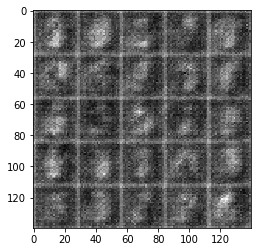

Epoch ... (1, 2)  Discriminator Loss:  1.03237  Generator Loss:  1.69848
Epoch ... (1, 2)  Discriminator Loss:  1.0079  Generator Loss:  1.3546
Epoch ... (1, 2)  Discriminator Loss:  1.24992  Generator Loss:  0.716256
Epoch ... (1, 2)  Discriminator Loss:  1.07417  Generator Loss:  1.35667
Epoch ... (1, 2)  Discriminator Loss:  1.11321  Generator Loss:  1.45354
Epoch ... (1, 2)  Discriminator Loss:  1.06942  Generator Loss:  1.14927
Epoch ... (1, 2)  Discriminator Loss:  1.12152  Generator Loss:  1.04423
Epoch ... (1, 2)  Discriminator Loss:  1.18986  Generator Loss:  0.850865
Epoch ... (1, 2)  Discriminator Loss:  1.17712  Generator Loss:  0.883199
Epoch ... (1, 2)  Discriminator Loss:  1.19028  Generator Loss:  0.820842
Training Value:  False
Tensor("generator_2/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


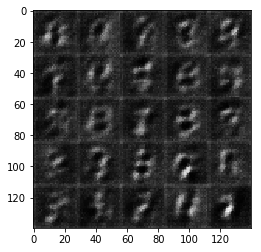

Epoch ... (1, 2)  Discriminator Loss:  1.28614  Generator Loss:  0.706561
Epoch ... (1, 2)  Discriminator Loss:  1.2148  Generator Loss:  1.40771
Epoch ... (1, 2)  Discriminator Loss:  1.22633  Generator Loss:  0.794691
Epoch ... (1, 2)  Discriminator Loss:  1.23663  Generator Loss:  0.778991
Epoch ... (1, 2)  Discriminator Loss:  1.25327  Generator Loss:  1.04425
Epoch ... (1, 2)  Discriminator Loss:  1.29123  Generator Loss:  0.706901
Epoch ... (1, 2)  Discriminator Loss:  1.2659  Generator Loss:  0.744282
Epoch ... (1, 2)  Discriminator Loss:  1.23433  Generator Loss:  0.804644
Epoch ... (1, 2)  Discriminator Loss:  1.24317  Generator Loss:  0.879944
Epoch ... (1, 2)  Discriminator Loss:  1.23245  Generator Loss:  0.853586
Training Value:  False
Tensor("generator_3/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


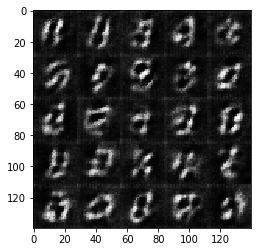

Epoch ... (1, 2)  Discriminator Loss:  1.21845  Generator Loss:  0.845823
Epoch ... (1, 2)  Discriminator Loss:  1.25559  Generator Loss:  0.880434
Epoch ... (1, 2)  Discriminator Loss:  1.23468  Generator Loss:  0.96605
Epoch ... (1, 2)  Discriminator Loss:  1.26794  Generator Loss:  0.758801
Epoch ... (1, 2)  Discriminator Loss:  1.21685  Generator Loss:  1.03419
Epoch ... (1, 2)  Discriminator Loss:  1.34413  Generator Loss:  1.37849
Epoch ... (1, 2)  Discriminator Loss:  1.23244  Generator Loss:  0.932044
Epoch ... (1, 2)  Discriminator Loss:  1.36376  Generator Loss:  0.606243
Epoch ... (1, 2)  Discriminator Loss:  1.27276  Generator Loss:  0.76927
Epoch ... (1, 2)  Discriminator Loss:  1.2638  Generator Loss:  0.93463
Training Value:  False
Tensor("generator_4/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


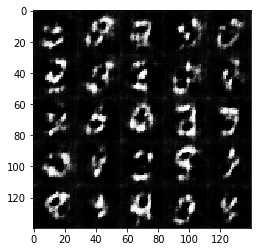

Epoch ... (1, 2)  Discriminator Loss:  1.30282  Generator Loss:  1.3444
Epoch ... (1, 2)  Discriminator Loss:  1.19967  Generator Loss:  0.974787
Epoch ... (1, 2)  Discriminator Loss:  1.16485  Generator Loss:  1.11463
Epoch ... (1, 2)  Discriminator Loss:  1.2415  Generator Loss:  0.735104
Epoch ... (1, 2)  Discriminator Loss:  1.23525  Generator Loss:  0.8379
Epoch ... (1, 2)  Discriminator Loss:  1.28185  Generator Loss:  0.699013
Epoch ... (1, 2)  Discriminator Loss:  1.20042  Generator Loss:  0.948198
Epoch ... (1, 2)  Discriminator Loss:  1.16879  Generator Loss:  1.03326
Epoch ... (1, 2)  Discriminator Loss:  1.21458  Generator Loss:  1.25384
Epoch ... (1, 2)  Discriminator Loss:  1.21087  Generator Loss:  0.927069
Training Value:  False
Tensor("generator_5/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


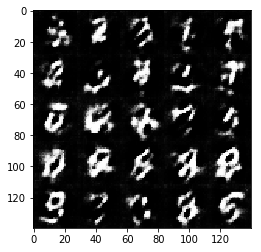

Epoch ... (1, 2)  Discriminator Loss:  1.17654  Generator Loss:  1.09775
Epoch ... (1, 2)  Discriminator Loss:  1.20801  Generator Loss:  1.26335
Epoch ... (1, 2)  Discriminator Loss:  1.2033  Generator Loss:  1.14566
Epoch ... (1, 2)  Discriminator Loss:  1.1813  Generator Loss:  1.05309
Epoch ... (1, 2)  Discriminator Loss:  1.19268  Generator Loss:  1.13457
Epoch ... (1, 2)  Discriminator Loss:  1.20183  Generator Loss:  1.16141
Epoch ... (1, 2)  Discriminator Loss:  1.20077  Generator Loss:  0.879672
Epoch ... (1, 2)  Discriminator Loss:  1.28848  Generator Loss:  1.61999
Epoch ... (1, 2)  Discriminator Loss:  1.20046  Generator Loss:  1.01466
Epoch ... (1, 2)  Discriminator Loss:  1.30268  Generator Loss:  1.05825
Training Value:  False
Tensor("generator_6/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


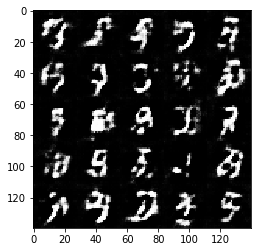

Epoch ... (1, 2)  Discriminator Loss:  1.1594  Generator Loss:  1.3075
Epoch ... (1, 2)  Discriminator Loss:  1.32368  Generator Loss:  0.646318
Epoch ... (1, 2)  Discriminator Loss:  1.21523  Generator Loss:  0.959158
Epoch ... (1, 2)  Discriminator Loss:  1.23772  Generator Loss:  1.39863
Epoch ... (1, 2)  Discriminator Loss:  1.16034  Generator Loss:  1.0612
Epoch ... (1, 2)  Discriminator Loss:  1.38246  Generator Loss:  1.63601
Epoch ... (1, 2)  Discriminator Loss:  1.19736  Generator Loss:  1.0175
Epoch ... (1, 2)  Discriminator Loss:  1.22987  Generator Loss:  1.61303
Epoch ... (1, 2)  Discriminator Loss:  1.2438  Generator Loss:  1.09504
Epoch ... (1, 2)  Discriminator Loss:  1.20616  Generator Loss:  0.773474
Training Value:  False
Tensor("generator_7/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


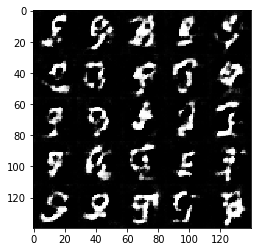

Epoch ... (1, 2)  Discriminator Loss:  1.18508  Generator Loss:  0.994746
Epoch ... (1, 2)  Discriminator Loss:  1.14273  Generator Loss:  1.13003
Epoch ... (1, 2)  Discriminator Loss:  1.23014  Generator Loss:  0.742241
Epoch ... (1, 2)  Discriminator Loss:  1.15268  Generator Loss:  0.949046
Epoch ... (1, 2)  Discriminator Loss:  1.18872  Generator Loss:  1.17022
Epoch ... (1, 2)  Discriminator Loss:  1.1712  Generator Loss:  1.30995
Epoch ... (1, 2)  Discriminator Loss:  1.16682  Generator Loss:  1.27172
Epoch ... (1, 2)  Discriminator Loss:  1.17415  Generator Loss:  1.10889
Epoch ... (1, 2)  Discriminator Loss:  1.38701  Generator Loss:  0.553372
Epoch ... (1, 2)  Discriminator Loss:  1.2237  Generator Loss:  0.890074
Training Value:  False
Tensor("generator_8/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


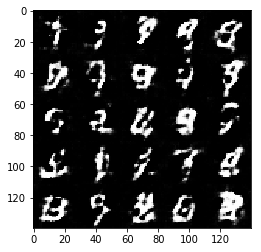

Epoch ... (1, 2)  Discriminator Loss:  1.1791  Generator Loss:  0.970316
Epoch ... (1, 2)  Discriminator Loss:  1.2069  Generator Loss:  0.898689
Epoch ... (1, 2)  Discriminator Loss:  1.17594  Generator Loss:  1.05731
Epoch ... (1, 2)  Discriminator Loss:  1.18224  Generator Loss:  1.21109
Epoch ... (1, 2)  Discriminator Loss:  1.1923  Generator Loss:  1.06166
Epoch ... (1, 2)  Discriminator Loss:  1.29044  Generator Loss:  0.68942
Epoch ... (1, 2)  Discriminator Loss:  1.17928  Generator Loss:  0.945967
Epoch ... (1, 2)  Discriminator Loss:  1.17679  Generator Loss:  1.1769
Epoch ... (1, 2)  Discriminator Loss:  1.18841  Generator Loss:  1.08769
Epoch ... (1, 2)  Discriminator Loss:  1.1801  Generator Loss:  0.868348
Training Value:  False
Tensor("generator_9/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


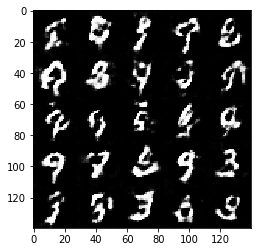

Epoch ... (1, 2)  Discriminator Loss:  1.23266  Generator Loss:  0.810162
Epoch ... (1, 2)  Discriminator Loss:  1.15782  Generator Loss:  1.04248
Epoch ... (1, 2)  Discriminator Loss:  1.16226  Generator Loss:  1.01495
Epoch ... (2, 2)  Discriminator Loss:  1.21442  Generator Loss:  1.31005
Epoch ... (2, 2)  Discriminator Loss:  1.18629  Generator Loss:  0.952252
Epoch ... (2, 2)  Discriminator Loss:  1.21268  Generator Loss:  1.37465
Epoch ... (2, 2)  Discriminator Loss:  1.21044  Generator Loss:  0.876613
Epoch ... (2, 2)  Discriminator Loss:  1.17857  Generator Loss:  1.26588
Epoch ... (2, 2)  Discriminator Loss:  1.1382  Generator Loss:  1.01659
Epoch ... (2, 2)  Discriminator Loss:  1.21604  Generator Loss:  0.803629
Training Value:  False
Tensor("generator_10/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


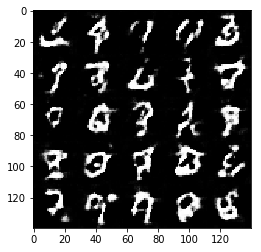

Epoch ... (2, 2)  Discriminator Loss:  1.35041  Generator Loss:  1.78867
Epoch ... (2, 2)  Discriminator Loss:  1.1793  Generator Loss:  1.04701
Epoch ... (2, 2)  Discriminator Loss:  1.17578  Generator Loss:  1.24858
Epoch ... (2, 2)  Discriminator Loss:  1.15338  Generator Loss:  1.1371
Epoch ... (2, 2)  Discriminator Loss:  1.12212  Generator Loss:  1.11864
Epoch ... (2, 2)  Discriminator Loss:  1.21029  Generator Loss:  0.856833
Epoch ... (2, 2)  Discriminator Loss:  1.2124  Generator Loss:  1.17376
Epoch ... (2, 2)  Discriminator Loss:  1.1105  Generator Loss:  1.30311
Epoch ... (2, 2)  Discriminator Loss:  1.16272  Generator Loss:  1.04836
Epoch ... (2, 2)  Discriminator Loss:  1.15438  Generator Loss:  1.3973
Training Value:  False
Tensor("generator_11/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


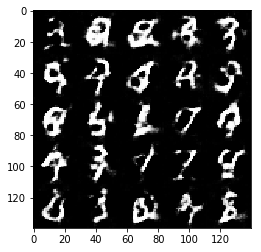

Epoch ... (2, 2)  Discriminator Loss:  1.16153  Generator Loss:  0.952251
Epoch ... (2, 2)  Discriminator Loss:  1.14815  Generator Loss:  1.0926
Epoch ... (2, 2)  Discriminator Loss:  1.13308  Generator Loss:  1.19247
Epoch ... (2, 2)  Discriminator Loss:  1.16524  Generator Loss:  1.65262
Epoch ... (2, 2)  Discriminator Loss:  1.16029  Generator Loss:  1.32821
Epoch ... (2, 2)  Discriminator Loss:  1.1675  Generator Loss:  0.956316
Epoch ... (2, 2)  Discriminator Loss:  1.12831  Generator Loss:  1.40061
Epoch ... (2, 2)  Discriminator Loss:  1.14579  Generator Loss:  1.12615
Epoch ... (2, 2)  Discriminator Loss:  1.20788  Generator Loss:  0.932548
Epoch ... (2, 2)  Discriminator Loss:  1.11002  Generator Loss:  1.50256
Training Value:  False
Tensor("generator_12/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


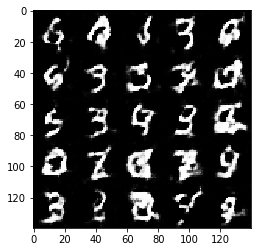

Epoch ... (2, 2)  Discriminator Loss:  1.16262  Generator Loss:  1.07943
Epoch ... (2, 2)  Discriminator Loss:  1.22898  Generator Loss:  0.761564
Epoch ... (2, 2)  Discriminator Loss:  1.16483  Generator Loss:  1.01969
Epoch ... (2, 2)  Discriminator Loss:  1.13791  Generator Loss:  1.17369
Epoch ... (2, 2)  Discriminator Loss:  1.15727  Generator Loss:  1.09656
Epoch ... (2, 2)  Discriminator Loss:  1.14556  Generator Loss:  1.21527
Epoch ... (2, 2)  Discriminator Loss:  1.15826  Generator Loss:  1.02288
Epoch ... (2, 2)  Discriminator Loss:  1.14939  Generator Loss:  1.14068
Epoch ... (2, 2)  Discriminator Loss:  1.17141  Generator Loss:  1.11478
Epoch ... (2, 2)  Discriminator Loss:  1.18978  Generator Loss:  1.42571
Training Value:  False
Tensor("generator_13/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


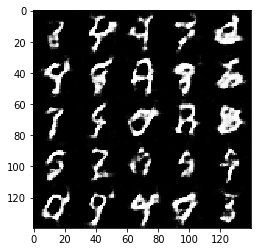

Epoch ... (2, 2)  Discriminator Loss:  1.09035  Generator Loss:  1.1502
Epoch ... (2, 2)  Discriminator Loss:  1.23882  Generator Loss:  1.42634
Epoch ... (2, 2)  Discriminator Loss:  1.15905  Generator Loss:  1.0858
Epoch ... (2, 2)  Discriminator Loss:  1.15457  Generator Loss:  1.29141
Epoch ... (2, 2)  Discriminator Loss:  1.18687  Generator Loss:  0.959854
Epoch ... (2, 2)  Discriminator Loss:  1.25461  Generator Loss:  1.60766
Epoch ... (2, 2)  Discriminator Loss:  1.15377  Generator Loss:  1.24871
Epoch ... (2, 2)  Discriminator Loss:  1.19702  Generator Loss:  0.919851
Epoch ... (2, 2)  Discriminator Loss:  1.18026  Generator Loss:  1.42493
Epoch ... (2, 2)  Discriminator Loss:  1.16738  Generator Loss:  1.21526
Training Value:  False
Tensor("generator_14/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


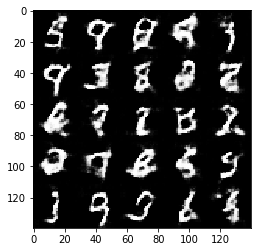

Epoch ... (2, 2)  Discriminator Loss:  1.18042  Generator Loss:  1.2541
Epoch ... (2, 2)  Discriminator Loss:  1.26662  Generator Loss:  0.939409
Epoch ... (2, 2)  Discriminator Loss:  1.23692  Generator Loss:  1.40063
Epoch ... (2, 2)  Discriminator Loss:  1.1887  Generator Loss:  1.09028
Epoch ... (2, 2)  Discriminator Loss:  1.21711  Generator Loss:  0.839919
Epoch ... (2, 2)  Discriminator Loss:  1.22472  Generator Loss:  1.50594
Epoch ... (2, 2)  Discriminator Loss:  1.19705  Generator Loss:  1.16661
Epoch ... (2, 2)  Discriminator Loss:  1.14462  Generator Loss:  1.01149
Epoch ... (2, 2)  Discriminator Loss:  1.19823  Generator Loss:  1.28053
Epoch ... (2, 2)  Discriminator Loss:  1.21646  Generator Loss:  1.44966
Training Value:  False
Tensor("generator_15/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


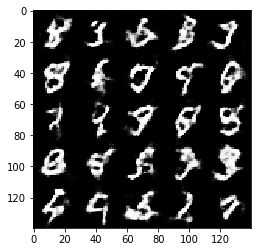

Epoch ... (2, 2)  Discriminator Loss:  1.18128  Generator Loss:  1.11392
Epoch ... (2, 2)  Discriminator Loss:  1.23799  Generator Loss:  0.909549
Epoch ... (2, 2)  Discriminator Loss:  1.19402  Generator Loss:  1.0489
Epoch ... (2, 2)  Discriminator Loss:  1.14757  Generator Loss:  1.08359
Epoch ... (2, 2)  Discriminator Loss:  1.18164  Generator Loss:  1.21316
Epoch ... (2, 2)  Discriminator Loss:  1.216  Generator Loss:  1.18829
Epoch ... (2, 2)  Discriminator Loss:  1.21557  Generator Loss:  1.31764
Epoch ... (2, 2)  Discriminator Loss:  1.15006  Generator Loss:  1.05518
Epoch ... (2, 2)  Discriminator Loss:  1.17913  Generator Loss:  1.2456
Epoch ... (2, 2)  Discriminator Loss:  1.16835  Generator Loss:  0.993958
Training Value:  False
Tensor("generator_16/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


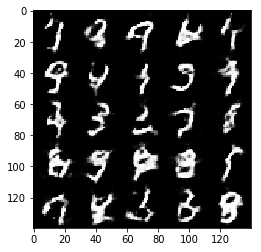

Epoch ... (2, 2)  Discriminator Loss:  1.20151  Generator Loss:  1.16644
Epoch ... (2, 2)  Discriminator Loss:  1.24617  Generator Loss:  0.801713
Epoch ... (2, 2)  Discriminator Loss:  1.1683  Generator Loss:  0.988584
Epoch ... (2, 2)  Discriminator Loss:  1.18602  Generator Loss:  1.13584
Epoch ... (2, 2)  Discriminator Loss:  1.19857  Generator Loss:  1.171
Epoch ... (2, 2)  Discriminator Loss:  1.18289  Generator Loss:  1.04934
Epoch ... (2, 2)  Discriminator Loss:  1.21441  Generator Loss:  1.21168
Epoch ... (2, 2)  Discriminator Loss:  1.1747  Generator Loss:  1.21687
Epoch ... (2, 2)  Discriminator Loss:  1.20641  Generator Loss:  1.26486
Epoch ... (2, 2)  Discriminator Loss:  1.19808  Generator Loss:  1.27495
Training Value:  False
Tensor("generator_17/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


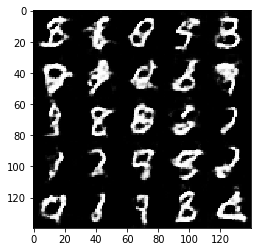

Epoch ... (2, 2)  Discriminator Loss:  1.15287  Generator Loss:  1.20508
Epoch ... (2, 2)  Discriminator Loss:  1.25907  Generator Loss:  1.43221
Epoch ... (2, 2)  Discriminator Loss:  1.20139  Generator Loss:  1.21067
Epoch ... (2, 2)  Discriminator Loss:  1.19933  Generator Loss:  1.25722
Epoch ... (2, 2)  Discriminator Loss:  1.2011  Generator Loss:  1.46226
Epoch ... (2, 2)  Discriminator Loss:  1.22591  Generator Loss:  1.35308
Epoch ... (2, 2)  Discriminator Loss:  1.20783  Generator Loss:  0.953731
Epoch ... (2, 2)  Discriminator Loss:  1.29487  Generator Loss:  0.757413
Epoch ... (2, 2)  Discriminator Loss:  1.22842  Generator Loss:  0.978497
Epoch ... (2, 2)  Discriminator Loss:  1.18543  Generator Loss:  1.17498
Training Value:  False
Tensor("generator_18/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


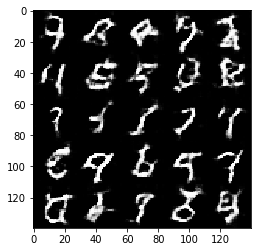

Epoch ... (2, 2)  Discriminator Loss:  1.24064  Generator Loss:  1.32769
Epoch ... (2, 2)  Discriminator Loss:  1.18821  Generator Loss:  1.19416
Epoch ... (2, 2)  Discriminator Loss:  1.18816  Generator Loss:  1.03643
Epoch ... (2, 2)  Discriminator Loss:  1.26467  Generator Loss:  0.849229
Epoch ... (2, 2)  Discriminator Loss:  1.19567  Generator Loss:  1.19216
Epoch ... (2, 2)  Discriminator Loss:  1.22319  Generator Loss:  1.30929
Epoch ... (2, 2)  Discriminator Loss:  1.19282  Generator Loss:  1.02198


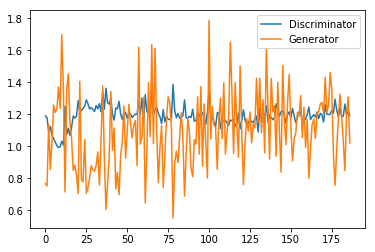

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Training Value:  True
Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)
Epoch ... (1, 1)  Discriminator Loss:  1.03237  Generator Loss:  0.624332
Epoch ... (1, 1)  Discriminator Loss:  0.926627  Generator Loss:  0.825359
Epoch ... (1, 1)  Discriminator Loss:  0.843334  Generator Loss:  1.15866
Epoch ... (1, 1)  Discriminator Loss:  0.842149  Generator Loss:  1.01983
Epoch ... (1, 1)  Discriminator Loss:  0.802527  Generator Loss:  1.09903
Epoch ... (1, 1)  Discriminator Loss:  0.834783  Generator Loss:  0.963353
Epoch ... (1, 1)  Discriminator Loss:  0.867944  Generator Loss:  0.899935
Epoch ... (1, 1)  Discriminator Loss:  0.806839  Generator Loss:  1.26446
Epoch ... (1, 1)  Discriminator Loss:  0.840448  Generator Loss:  1.48898
Epoch ... (1, 1)  Discriminator Loss:  0.856573  Generator Loss:  1.70482
Training Value:  False
Tensor("generator_1/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


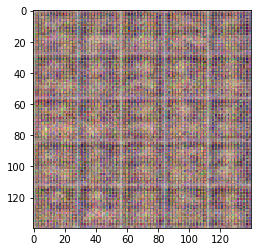

Epoch ... (1, 1)  Discriminator Loss:  0.829967  Generator Loss:  1.12843
Epoch ... (1, 1)  Discriminator Loss:  0.854124  Generator Loss:  1.06268
Epoch ... (1, 1)  Discriminator Loss:  0.860694  Generator Loss:  1.21523
Epoch ... (1, 1)  Discriminator Loss:  0.97407  Generator Loss:  0.947697
Epoch ... (1, 1)  Discriminator Loss:  0.911849  Generator Loss:  0.968383
Epoch ... (1, 1)  Discriminator Loss:  0.951353  Generator Loss:  0.805758
Epoch ... (1, 1)  Discriminator Loss:  1.01287  Generator Loss:  1.37378
Epoch ... (1, 1)  Discriminator Loss:  1.03697  Generator Loss:  0.560161
Epoch ... (1, 1)  Discriminator Loss:  0.936053  Generator Loss:  1.02947
Epoch ... (1, 1)  Discriminator Loss:  0.962425  Generator Loss:  0.757183
Training Value:  False
Tensor("generator_2/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


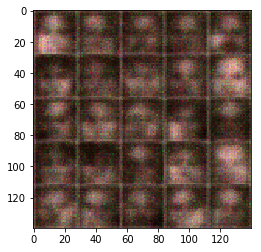

Epoch ... (1, 1)  Discriminator Loss:  1.01666  Generator Loss:  1.29363
Epoch ... (1, 1)  Discriminator Loss:  0.946362  Generator Loss:  0.981317
Epoch ... (1, 1)  Discriminator Loss:  0.991389  Generator Loss:  0.778181
Epoch ... (1, 1)  Discriminator Loss:  1.03306  Generator Loss:  1.40826
Epoch ... (1, 1)  Discriminator Loss:  0.952249  Generator Loss:  0.981002
Epoch ... (1, 1)  Discriminator Loss:  0.996389  Generator Loss:  0.630144
Epoch ... (1, 1)  Discriminator Loss:  1.05789  Generator Loss:  0.520606
Epoch ... (1, 1)  Discriminator Loss:  1.06144  Generator Loss:  0.498888
Epoch ... (1, 1)  Discriminator Loss:  0.970441  Generator Loss:  0.962015
Epoch ... (1, 1)  Discriminator Loss:  1.00594  Generator Loss:  0.611975
Training Value:  False
Tensor("generator_3/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


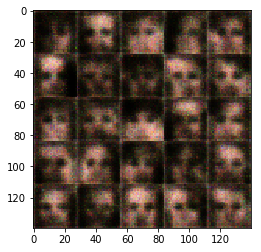

Epoch ... (1, 1)  Discriminator Loss:  0.939181  Generator Loss:  1.11823
Epoch ... (1, 1)  Discriminator Loss:  0.929752  Generator Loss:  1.03711
Epoch ... (1, 1)  Discriminator Loss:  1.46711  Generator Loss:  0.258884
Epoch ... (1, 1)  Discriminator Loss:  0.945085  Generator Loss:  0.907651
Epoch ... (1, 1)  Discriminator Loss:  0.950983  Generator Loss:  0.978156
Epoch ... (1, 1)  Discriminator Loss:  0.937864  Generator Loss:  0.98776
Epoch ... (1, 1)  Discriminator Loss:  1.20905  Generator Loss:  0.36696
Epoch ... (1, 1)  Discriminator Loss:  1.06509  Generator Loss:  1.53074
Epoch ... (1, 1)  Discriminator Loss:  0.958602  Generator Loss:  0.703647
Epoch ... (1, 1)  Discriminator Loss:  0.953002  Generator Loss:  0.792251
Training Value:  False
Tensor("generator_4/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


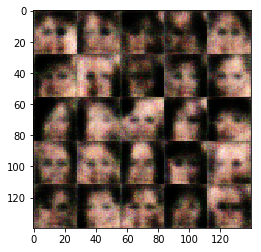

Epoch ... (1, 1)  Discriminator Loss:  1.03227  Generator Loss:  1.54868
Epoch ... (1, 1)  Discriminator Loss:  1.01475  Generator Loss:  0.676839
Epoch ... (1, 1)  Discriminator Loss:  0.880661  Generator Loss:  1.00362
Epoch ... (1, 1)  Discriminator Loss:  0.932364  Generator Loss:  1.09978
Epoch ... (1, 1)  Discriminator Loss:  0.987539  Generator Loss:  0.735077
Epoch ... (1, 1)  Discriminator Loss:  0.99114  Generator Loss:  0.779923
Epoch ... (1, 1)  Discriminator Loss:  1.03592  Generator Loss:  0.565489
Epoch ... (1, 1)  Discriminator Loss:  1.01861  Generator Loss:  1.10275
Epoch ... (1, 1)  Discriminator Loss:  0.966435  Generator Loss:  0.695302
Epoch ... (1, 1)  Discriminator Loss:  0.985461  Generator Loss:  0.821798
Training Value:  False
Tensor("generator_5/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


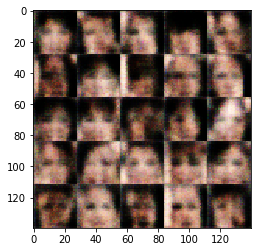

Epoch ... (1, 1)  Discriminator Loss:  1.03932  Generator Loss:  1.28302
Epoch ... (1, 1)  Discriminator Loss:  1.00626  Generator Loss:  0.986674
Epoch ... (1, 1)  Discriminator Loss:  1.09795  Generator Loss:  1.20674
Epoch ... (1, 1)  Discriminator Loss:  1.04783  Generator Loss:  0.573273
Epoch ... (1, 1)  Discriminator Loss:  1.04974  Generator Loss:  0.874075
Epoch ... (1, 1)  Discriminator Loss:  1.0955  Generator Loss:  0.599555
Epoch ... (1, 1)  Discriminator Loss:  1.06456  Generator Loss:  1.15283
Epoch ... (1, 1)  Discriminator Loss:  1.041  Generator Loss:  1.01807
Epoch ... (1, 1)  Discriminator Loss:  1.03968  Generator Loss:  0.630069
Epoch ... (1, 1)  Discriminator Loss:  1.06914  Generator Loss:  0.880934
Training Value:  False
Tensor("generator_6/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


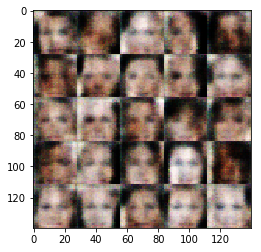

Epoch ... (1, 1)  Discriminator Loss:  0.952181  Generator Loss:  0.989128
Epoch ... (1, 1)  Discriminator Loss:  1.14527  Generator Loss:  0.690725
Epoch ... (1, 1)  Discriminator Loss:  1.07311  Generator Loss:  0.662354
Epoch ... (1, 1)  Discriminator Loss:  1.12211  Generator Loss:  0.540765
Epoch ... (1, 1)  Discriminator Loss:  1.09898  Generator Loss:  0.560404
Epoch ... (1, 1)  Discriminator Loss:  1.14755  Generator Loss:  0.657441
Epoch ... (1, 1)  Discriminator Loss:  1.03411  Generator Loss:  0.841103
Epoch ... (1, 1)  Discriminator Loss:  1.12277  Generator Loss:  0.851069
Epoch ... (1, 1)  Discriminator Loss:  1.09176  Generator Loss:  0.618871
Epoch ... (1, 1)  Discriminator Loss:  1.05686  Generator Loss:  0.723806
Training Value:  False
Tensor("generator_7/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


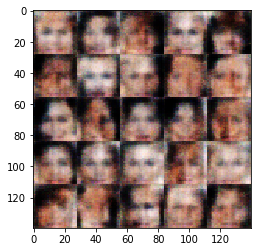

Epoch ... (1, 1)  Discriminator Loss:  1.06793  Generator Loss:  0.727442
Epoch ... (1, 1)  Discriminator Loss:  1.13559  Generator Loss:  0.633399
Epoch ... (1, 1)  Discriminator Loss:  1.0868  Generator Loss:  0.60326
Epoch ... (1, 1)  Discriminator Loss:  1.14512  Generator Loss:  0.644424
Epoch ... (1, 1)  Discriminator Loss:  1.09952  Generator Loss:  0.658228
Epoch ... (1, 1)  Discriminator Loss:  1.19247  Generator Loss:  0.519394
Epoch ... (1, 1)  Discriminator Loss:  1.11864  Generator Loss:  0.836242
Epoch ... (1, 1)  Discriminator Loss:  1.16632  Generator Loss:  0.624208
Epoch ... (1, 1)  Discriminator Loss:  1.1326  Generator Loss:  0.727322
Epoch ... (1, 1)  Discriminator Loss:  1.13668  Generator Loss:  0.712499
Training Value:  False
Tensor("generator_8/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


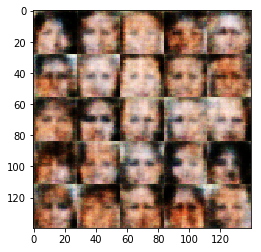

Epoch ... (1, 1)  Discriminator Loss:  1.15838  Generator Loss:  0.597334
Epoch ... (1, 1)  Discriminator Loss:  1.14549  Generator Loss:  0.616705
Epoch ... (1, 1)  Discriminator Loss:  1.19832  Generator Loss:  0.569501
Epoch ... (1, 1)  Discriminator Loss:  1.10901  Generator Loss:  0.751981
Epoch ... (1, 1)  Discriminator Loss:  1.12249  Generator Loss:  0.75109
Epoch ... (1, 1)  Discriminator Loss:  1.16782  Generator Loss:  0.767307
Epoch ... (1, 1)  Discriminator Loss:  1.16305  Generator Loss:  0.636402
Epoch ... (1, 1)  Discriminator Loss:  1.1438  Generator Loss:  0.641406
Epoch ... (1, 1)  Discriminator Loss:  1.11285  Generator Loss:  0.99989
Epoch ... (1, 1)  Discriminator Loss:  1.15837  Generator Loss:  0.616648
Training Value:  False
Tensor("generator_9/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


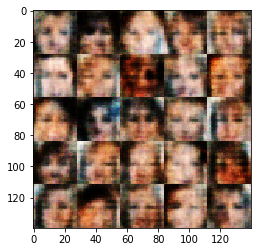

Epoch ... (1, 1)  Discriminator Loss:  1.18202  Generator Loss:  0.760408
Epoch ... (1, 1)  Discriminator Loss:  1.22402  Generator Loss:  0.631666
Epoch ... (1, 1)  Discriminator Loss:  1.1126  Generator Loss:  0.677478
Epoch ... (1, 1)  Discriminator Loss:  1.18254  Generator Loss:  0.575563
Epoch ... (1, 1)  Discriminator Loss:  1.19679  Generator Loss:  0.559558
Epoch ... (1, 1)  Discriminator Loss:  1.09527  Generator Loss:  0.762253
Epoch ... (1, 1)  Discriminator Loss:  1.17535  Generator Loss:  0.600298
Epoch ... (1, 1)  Discriminator Loss:  1.19773  Generator Loss:  0.577811
Epoch ... (1, 1)  Discriminator Loss:  1.15872  Generator Loss:  0.5685
Epoch ... (1, 1)  Discriminator Loss:  1.27586  Generator Loss:  0.488681
Training Value:  False
Tensor("generator_10/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


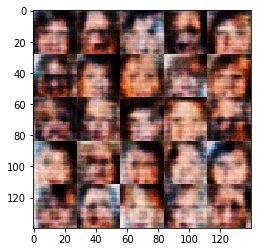

Epoch ... (1, 1)  Discriminator Loss:  1.14598  Generator Loss:  0.700849
Epoch ... (1, 1)  Discriminator Loss:  1.26052  Generator Loss:  0.595993
Epoch ... (1, 1)  Discriminator Loss:  1.13412  Generator Loss:  0.589544
Epoch ... (1, 1)  Discriminator Loss:  1.20639  Generator Loss:  0.621769
Epoch ... (1, 1)  Discriminator Loss:  1.15697  Generator Loss:  0.615721
Epoch ... (1, 1)  Discriminator Loss:  1.2142  Generator Loss:  0.616183
Epoch ... (1, 1)  Discriminator Loss:  1.25852  Generator Loss:  0.544646
Epoch ... (1, 1)  Discriminator Loss:  1.23755  Generator Loss:  0.639281
Epoch ... (1, 1)  Discriminator Loss:  1.19282  Generator Loss:  0.651314
Epoch ... (1, 1)  Discriminator Loss:  1.20041  Generator Loss:  0.622964
Training Value:  False
Tensor("generator_11/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


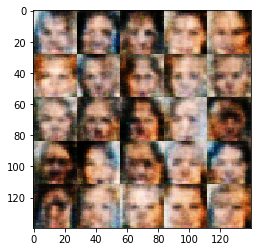

Epoch ... (1, 1)  Discriminator Loss:  1.22504  Generator Loss:  0.590632
Epoch ... (1, 1)  Discriminator Loss:  1.20103  Generator Loss:  0.588895
Epoch ... (1, 1)  Discriminator Loss:  1.21699  Generator Loss:  0.444284
Epoch ... (1, 1)  Discriminator Loss:  1.21624  Generator Loss:  0.480327
Epoch ... (1, 1)  Discriminator Loss:  1.12159  Generator Loss:  0.703759
Epoch ... (1, 1)  Discriminator Loss:  1.24803  Generator Loss:  0.547513
Epoch ... (1, 1)  Discriminator Loss:  1.17244  Generator Loss:  0.719299
Epoch ... (1, 1)  Discriminator Loss:  1.1831  Generator Loss:  0.571974
Epoch ... (1, 1)  Discriminator Loss:  1.21485  Generator Loss:  0.713213
Epoch ... (1, 1)  Discriminator Loss:  1.20655  Generator Loss:  0.62785
Training Value:  False
Tensor("generator_12/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


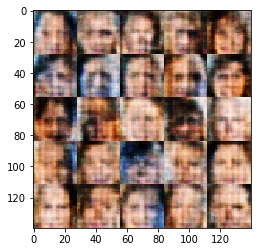

Epoch ... (1, 1)  Discriminator Loss:  1.2364  Generator Loss:  0.583421
Epoch ... (1, 1)  Discriminator Loss:  1.17776  Generator Loss:  0.689656
Epoch ... (1, 1)  Discriminator Loss:  1.19799  Generator Loss:  0.636587
Epoch ... (1, 1)  Discriminator Loss:  1.28085  Generator Loss:  0.545896
Epoch ... (1, 1)  Discriminator Loss:  1.18253  Generator Loss:  0.608599
Epoch ... (1, 1)  Discriminator Loss:  1.23849  Generator Loss:  0.575674
Epoch ... (1, 1)  Discriminator Loss:  1.1958  Generator Loss:  0.583119
Epoch ... (1, 1)  Discriminator Loss:  1.22698  Generator Loss:  0.617475
Epoch ... (1, 1)  Discriminator Loss:  1.21908  Generator Loss:  0.548068
Epoch ... (1, 1)  Discriminator Loss:  1.2124  Generator Loss:  0.529815
Training Value:  False
Tensor("generator_13/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


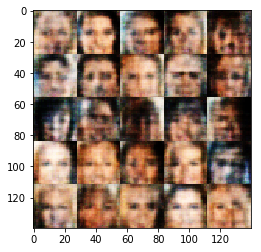

Epoch ... (1, 1)  Discriminator Loss:  1.25376  Generator Loss:  0.551965
Epoch ... (1, 1)  Discriminator Loss:  1.20632  Generator Loss:  0.607607
Epoch ... (1, 1)  Discriminator Loss:  1.24707  Generator Loss:  0.602649
Epoch ... (1, 1)  Discriminator Loss:  1.18838  Generator Loss:  0.624702
Epoch ... (1, 1)  Discriminator Loss:  1.28159  Generator Loss:  0.474054
Epoch ... (1, 1)  Discriminator Loss:  1.19456  Generator Loss:  0.643729
Epoch ... (1, 1)  Discriminator Loss:  1.30053  Generator Loss:  0.56618
Epoch ... (1, 1)  Discriminator Loss:  1.17488  Generator Loss:  0.591474
Epoch ... (1, 1)  Discriminator Loss:  1.2614  Generator Loss:  0.518566
Epoch ... (1, 1)  Discriminator Loss:  1.22903  Generator Loss:  0.558314
Training Value:  False
Tensor("generator_14/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


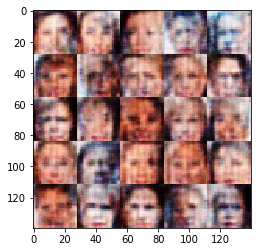

Epoch ... (1, 1)  Discriminator Loss:  1.23092  Generator Loss:  0.680926
Epoch ... (1, 1)  Discriminator Loss:  1.25746  Generator Loss:  0.592374
Epoch ... (1, 1)  Discriminator Loss:  1.20826  Generator Loss:  0.59482
Epoch ... (1, 1)  Discriminator Loss:  1.21999  Generator Loss:  0.570736
Epoch ... (1, 1)  Discriminator Loss:  1.22931  Generator Loss:  0.552546
Epoch ... (1, 1)  Discriminator Loss:  1.2549  Generator Loss:  0.533754
Epoch ... (1, 1)  Discriminator Loss:  1.24632  Generator Loss:  0.543728
Epoch ... (1, 1)  Discriminator Loss:  1.21365  Generator Loss:  0.623081
Epoch ... (1, 1)  Discriminator Loss:  1.22737  Generator Loss:  0.652435
Epoch ... (1, 1)  Discriminator Loss:  1.22205  Generator Loss:  0.581751
Training Value:  False
Tensor("generator_15/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


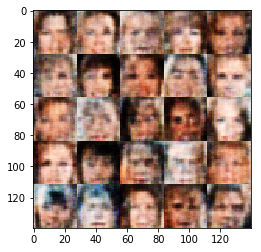

Epoch ... (1, 1)  Discriminator Loss:  1.27834  Generator Loss:  0.540853
Epoch ... (1, 1)  Discriminator Loss:  1.21291  Generator Loss:  0.588281
Epoch ... (1, 1)  Discriminator Loss:  1.26444  Generator Loss:  0.513988
Epoch ... (1, 1)  Discriminator Loss:  1.20145  Generator Loss:  0.553592
Epoch ... (1, 1)  Discriminator Loss:  1.27312  Generator Loss:  0.505978
Epoch ... (1, 1)  Discriminator Loss:  1.22033  Generator Loss:  0.559538
Epoch ... (1, 1)  Discriminator Loss:  1.24769  Generator Loss:  0.537816
Epoch ... (1, 1)  Discriminator Loss:  1.26175  Generator Loss:  0.56437
Epoch ... (1, 1)  Discriminator Loss:  1.26221  Generator Loss:  0.547423
Epoch ... (1, 1)  Discriminator Loss:  1.2335  Generator Loss:  0.596869
Training Value:  False
Tensor("generator_16/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


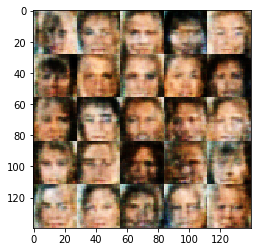

Epoch ... (1, 1)  Discriminator Loss:  1.27018  Generator Loss:  0.540226
Epoch ... (1, 1)  Discriminator Loss:  1.261  Generator Loss:  0.568126
Epoch ... (1, 1)  Discriminator Loss:  1.2563  Generator Loss:  0.587178
Epoch ... (1, 1)  Discriminator Loss:  1.24814  Generator Loss:  0.569057
Epoch ... (1, 1)  Discriminator Loss:  1.23221  Generator Loss:  0.524629
Epoch ... (1, 1)  Discriminator Loss:  1.2491  Generator Loss:  0.507095
Epoch ... (1, 1)  Discriminator Loss:  1.23867  Generator Loss:  0.561431
Epoch ... (1, 1)  Discriminator Loss:  1.23457  Generator Loss:  0.440511
Epoch ... (1, 1)  Discriminator Loss:  1.24309  Generator Loss:  0.54258
Epoch ... (1, 1)  Discriminator Loss:  1.23713  Generator Loss:  0.552839
Training Value:  False
Tensor("generator_17/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


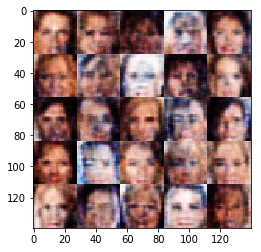

Epoch ... (1, 1)  Discriminator Loss:  1.20666  Generator Loss:  0.569985
Epoch ... (1, 1)  Discriminator Loss:  1.27441  Generator Loss:  0.551975
Epoch ... (1, 1)  Discriminator Loss:  1.18331  Generator Loss:  0.565933
Epoch ... (1, 1)  Discriminator Loss:  1.28593  Generator Loss:  0.554945
Epoch ... (1, 1)  Discriminator Loss:  1.21188  Generator Loss:  0.541349
Epoch ... (1, 1)  Discriminator Loss:  1.31686  Generator Loss:  0.473378
Epoch ... (1, 1)  Discriminator Loss:  1.23633  Generator Loss:  0.584929
Epoch ... (1, 1)  Discriminator Loss:  1.25589  Generator Loss:  0.499676
Epoch ... (1, 1)  Discriminator Loss:  1.25115  Generator Loss:  0.539965
Epoch ... (1, 1)  Discriminator Loss:  1.21945  Generator Loss:  0.571513
Training Value:  False
Tensor("generator_18/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


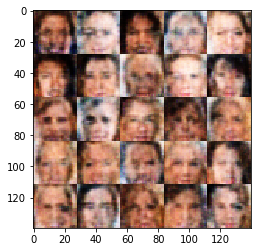

Epoch ... (1, 1)  Discriminator Loss:  1.29989  Generator Loss:  0.604082
Epoch ... (1, 1)  Discriminator Loss:  1.2108  Generator Loss:  0.541638
Epoch ... (1, 1)  Discriminator Loss:  1.28741  Generator Loss:  0.54106
Epoch ... (1, 1)  Discriminator Loss:  1.2435  Generator Loss:  0.543716
Epoch ... (1, 1)  Discriminator Loss:  1.26224  Generator Loss:  0.570985
Epoch ... (1, 1)  Discriminator Loss:  1.27669  Generator Loss:  0.571543
Epoch ... (1, 1)  Discriminator Loss:  1.26103  Generator Loss:  0.56703
Epoch ... (1, 1)  Discriminator Loss:  1.23942  Generator Loss:  0.580306
Epoch ... (1, 1)  Discriminator Loss:  1.25203  Generator Loss:  0.512377
Epoch ... (1, 1)  Discriminator Loss:  1.20256  Generator Loss:  0.567455
Training Value:  False
Tensor("generator_19/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


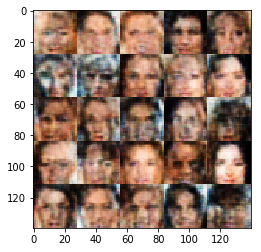

Epoch ... (1, 1)  Discriminator Loss:  1.24232  Generator Loss:  0.626605
Epoch ... (1, 1)  Discriminator Loss:  1.2307  Generator Loss:  0.544829
Epoch ... (1, 1)  Discriminator Loss:  1.27607  Generator Loss:  0.544099
Epoch ... (1, 1)  Discriminator Loss:  1.22249  Generator Loss:  0.589471
Epoch ... (1, 1)  Discriminator Loss:  1.26104  Generator Loss:  0.47882
Epoch ... (1, 1)  Discriminator Loss:  1.204  Generator Loss:  0.539996
Epoch ... (1, 1)  Discriminator Loss:  1.27583  Generator Loss:  0.484095
Epoch ... (1, 1)  Discriminator Loss:  1.24024  Generator Loss:  0.590416
Epoch ... (1, 1)  Discriminator Loss:  1.23671  Generator Loss:  0.517781
Epoch ... (1, 1)  Discriminator Loss:  1.21217  Generator Loss:  0.568396
Training Value:  False
Tensor("generator_20/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


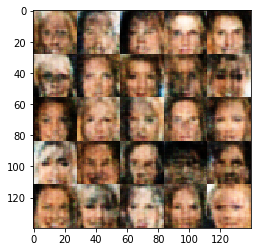

Epoch ... (1, 1)  Discriminator Loss:  1.26602  Generator Loss:  0.526718
Epoch ... (1, 1)  Discriminator Loss:  1.17693  Generator Loss:  0.591382
Epoch ... (1, 1)  Discriminator Loss:  1.25043  Generator Loss:  0.647046
Epoch ... (1, 1)  Discriminator Loss:  1.18234  Generator Loss:  0.573346
Epoch ... (1, 1)  Discriminator Loss:  1.23514  Generator Loss:  0.609702
Epoch ... (1, 1)  Discriminator Loss:  1.20646  Generator Loss:  0.519385
Epoch ... (1, 1)  Discriminator Loss:  1.26084  Generator Loss:  0.543865
Epoch ... (1, 1)  Discriminator Loss:  1.20942  Generator Loss:  0.565342
Epoch ... (1, 1)  Discriminator Loss:  1.32094  Generator Loss:  0.556378
Epoch ... (1, 1)  Discriminator Loss:  1.22904  Generator Loss:  0.575943
Training Value:  False
Tensor("generator_21/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


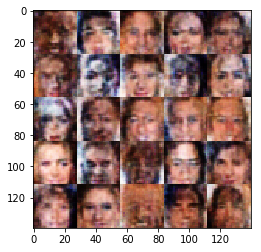

Epoch ... (1, 1)  Discriminator Loss:  1.24744  Generator Loss:  0.554393
Epoch ... (1, 1)  Discriminator Loss:  1.20989  Generator Loss:  0.59053
Epoch ... (1, 1)  Discriminator Loss:  1.2834  Generator Loss:  0.605042
Epoch ... (1, 1)  Discriminator Loss:  1.16596  Generator Loss:  0.604194
Epoch ... (1, 1)  Discriminator Loss:  1.27476  Generator Loss:  0.519793
Epoch ... (1, 1)  Discriminator Loss:  1.19777  Generator Loss:  0.586176
Epoch ... (1, 1)  Discriminator Loss:  1.33214  Generator Loss:  0.617095
Epoch ... (1, 1)  Discriminator Loss:  1.21625  Generator Loss:  0.55993
Epoch ... (1, 1)  Discriminator Loss:  1.20441  Generator Loss:  0.563247
Epoch ... (1, 1)  Discriminator Loss:  1.17577  Generator Loss:  0.614835
Training Value:  False
Tensor("generator_22/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


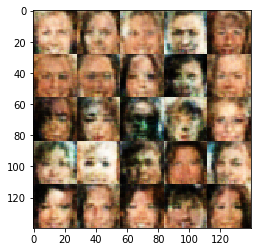

Epoch ... (1, 1)  Discriminator Loss:  1.35414  Generator Loss:  0.529736
Epoch ... (1, 1)  Discriminator Loss:  1.21015  Generator Loss:  0.522101
Epoch ... (1, 1)  Discriminator Loss:  1.2879  Generator Loss:  0.53731
Epoch ... (1, 1)  Discriminator Loss:  1.25083  Generator Loss:  0.627083
Epoch ... (1, 1)  Discriminator Loss:  1.27098  Generator Loss:  0.60613
Epoch ... (1, 1)  Discriminator Loss:  1.18952  Generator Loss:  0.56657
Epoch ... (1, 1)  Discriminator Loss:  1.248  Generator Loss:  0.540534
Epoch ... (1, 1)  Discriminator Loss:  1.21912  Generator Loss:  0.564183
Epoch ... (1, 1)  Discriminator Loss:  1.28829  Generator Loss:  0.564737
Epoch ... (1, 1)  Discriminator Loss:  1.16782  Generator Loss:  0.584912
Training Value:  False
Tensor("generator_23/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


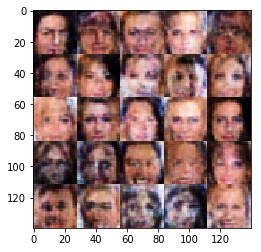

Epoch ... (1, 1)  Discriminator Loss:  1.23605  Generator Loss:  0.581014
Epoch ... (1, 1)  Discriminator Loss:  1.22529  Generator Loss:  0.531881
Epoch ... (1, 1)  Discriminator Loss:  1.32898  Generator Loss:  0.362311
Epoch ... (1, 1)  Discriminator Loss:  1.22262  Generator Loss:  0.6074
Epoch ... (1, 1)  Discriminator Loss:  1.22746  Generator Loss:  0.542128
Epoch ... (1, 1)  Discriminator Loss:  1.29607  Generator Loss:  0.556439
Epoch ... (1, 1)  Discriminator Loss:  1.2524  Generator Loss:  0.537002
Epoch ... (1, 1)  Discriminator Loss:  1.21446  Generator Loss:  0.561234
Epoch ... (1, 1)  Discriminator Loss:  1.22223  Generator Loss:  0.540258
Epoch ... (1, 1)  Discriminator Loss:  1.21613  Generator Loss:  0.655262
Training Value:  False
Tensor("generator_24/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


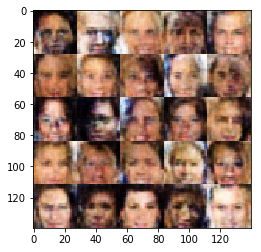

Epoch ... (1, 1)  Discriminator Loss:  1.26055  Generator Loss:  0.575996
Epoch ... (1, 1)  Discriminator Loss:  1.21311  Generator Loss:  0.539616
Epoch ... (1, 1)  Discriminator Loss:  1.22404  Generator Loss:  0.554237
Epoch ... (1, 1)  Discriminator Loss:  1.2448  Generator Loss:  0.51656
Epoch ... (1, 1)  Discriminator Loss:  1.20752  Generator Loss:  0.645897
Epoch ... (1, 1)  Discriminator Loss:  1.22914  Generator Loss:  0.482385
Epoch ... (1, 1)  Discriminator Loss:  1.26551  Generator Loss:  0.534995
Epoch ... (1, 1)  Discriminator Loss:  1.24357  Generator Loss:  0.539892
Epoch ... (1, 1)  Discriminator Loss:  1.23966  Generator Loss:  0.663089
Epoch ... (1, 1)  Discriminator Loss:  1.26422  Generator Loss:  0.53422
Training Value:  False
Tensor("generator_25/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


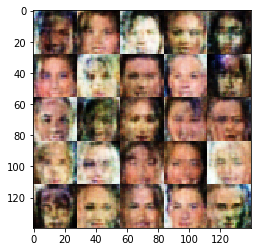

Epoch ... (1, 1)  Discriminator Loss:  1.26836  Generator Loss:  0.54527
Epoch ... (1, 1)  Discriminator Loss:  1.27731  Generator Loss:  0.566102
Epoch ... (1, 1)  Discriminator Loss:  1.21003  Generator Loss:  0.582209
Epoch ... (1, 1)  Discriminator Loss:  1.26226  Generator Loss:  0.552725
Epoch ... (1, 1)  Discriminator Loss:  1.23087  Generator Loss:  0.585465
Epoch ... (1, 1)  Discriminator Loss:  1.23756  Generator Loss:  0.569543
Epoch ... (1, 1)  Discriminator Loss:  1.28806  Generator Loss:  0.531076
Epoch ... (1, 1)  Discriminator Loss:  1.25764  Generator Loss:  0.526918
Epoch ... (1, 1)  Discriminator Loss:  1.25875  Generator Loss:  0.547638
Epoch ... (1, 1)  Discriminator Loss:  1.23435  Generator Loss:  0.566615
Training Value:  False
Tensor("generator_26/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


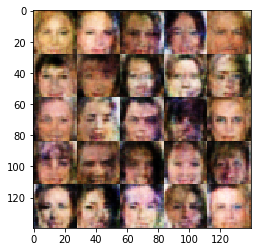

Epoch ... (1, 1)  Discriminator Loss:  1.29001  Generator Loss:  0.516349
Epoch ... (1, 1)  Discriminator Loss:  1.25897  Generator Loss:  0.562689
Epoch ... (1, 1)  Discriminator Loss:  1.21279  Generator Loss:  0.539324
Epoch ... (1, 1)  Discriminator Loss:  1.23341  Generator Loss:  0.567046
Epoch ... (1, 1)  Discriminator Loss:  1.26372  Generator Loss:  0.548546
Epoch ... (1, 1)  Discriminator Loss:  1.2354  Generator Loss:  0.534223
Epoch ... (1, 1)  Discriminator Loss:  1.228  Generator Loss:  0.501504
Epoch ... (1, 1)  Discriminator Loss:  1.21002  Generator Loss:  0.524583
Epoch ... (1, 1)  Discriminator Loss:  1.23682  Generator Loss:  0.549677
Epoch ... (1, 1)  Discriminator Loss:  1.28853  Generator Loss:  0.511056
Training Value:  False
Tensor("generator_27/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


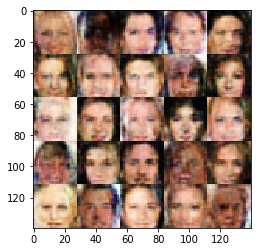

Epoch ... (1, 1)  Discriminator Loss:  1.26481  Generator Loss:  0.481447
Epoch ... (1, 1)  Discriminator Loss:  1.24698  Generator Loss:  0.539663
Epoch ... (1, 1)  Discriminator Loss:  1.25136  Generator Loss:  0.563288
Epoch ... (1, 1)  Discriminator Loss:  1.23316  Generator Loss:  0.571728
Epoch ... (1, 1)  Discriminator Loss:  1.26036  Generator Loss:  0.518268
Epoch ... (1, 1)  Discriminator Loss:  1.2488  Generator Loss:  0.534101
Epoch ... (1, 1)  Discriminator Loss:  1.28165  Generator Loss:  0.526779
Epoch ... (1, 1)  Discriminator Loss:  1.22375  Generator Loss:  0.58959
Epoch ... (1, 1)  Discriminator Loss:  1.25156  Generator Loss:  0.541579
Epoch ... (1, 1)  Discriminator Loss:  1.28021  Generator Loss:  0.551401
Training Value:  False
Tensor("generator_28/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


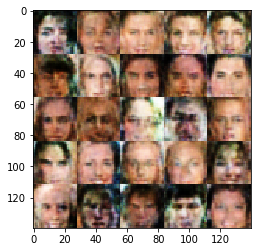

Epoch ... (1, 1)  Discriminator Loss:  1.22678  Generator Loss:  0.529259
Epoch ... (1, 1)  Discriminator Loss:  1.26694  Generator Loss:  0.561863
Epoch ... (1, 1)  Discriminator Loss:  1.25212  Generator Loss:  0.54565
Epoch ... (1, 1)  Discriminator Loss:  1.26076  Generator Loss:  0.552466
Epoch ... (1, 1)  Discriminator Loss:  1.2268  Generator Loss:  0.575294
Epoch ... (1, 1)  Discriminator Loss:  1.25398  Generator Loss:  0.510295
Epoch ... (1, 1)  Discriminator Loss:  1.24782  Generator Loss:  0.566837
Epoch ... (1, 1)  Discriminator Loss:  1.28272  Generator Loss:  0.536294
Epoch ... (1, 1)  Discriminator Loss:  1.23568  Generator Loss:  0.520952
Epoch ... (1, 1)  Discriminator Loss:  1.27346  Generator Loss:  0.526068
Training Value:  False
Tensor("generator_29/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


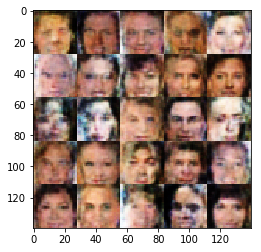

Epoch ... (1, 1)  Discriminator Loss:  1.21908  Generator Loss:  0.534984
Epoch ... (1, 1)  Discriminator Loss:  1.20071  Generator Loss:  0.593068
Epoch ... (1, 1)  Discriminator Loss:  1.2162  Generator Loss:  0.515302
Epoch ... (1, 1)  Discriminator Loss:  1.23182  Generator Loss:  0.575205
Epoch ... (1, 1)  Discriminator Loss:  1.23228  Generator Loss:  0.617024
Epoch ... (1, 1)  Discriminator Loss:  1.22503  Generator Loss:  0.581231
Epoch ... (1, 1)  Discriminator Loss:  1.2512  Generator Loss:  0.563943
Epoch ... (1, 1)  Discriminator Loss:  1.2313  Generator Loss:  0.595414
Epoch ... (1, 1)  Discriminator Loss:  1.20674  Generator Loss:  0.551522
Epoch ... (1, 1)  Discriminator Loss:  1.17977  Generator Loss:  0.607297
Training Value:  False
Tensor("generator_30/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


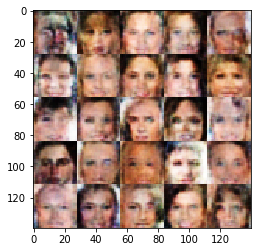

Epoch ... (1, 1)  Discriminator Loss:  1.30027  Generator Loss:  0.567886
Epoch ... (1, 1)  Discriminator Loss:  1.23771  Generator Loss:  0.558548
Epoch ... (1, 1)  Discriminator Loss:  1.22887  Generator Loss:  0.486216
Epoch ... (1, 1)  Discriminator Loss:  1.27249  Generator Loss:  0.596842
Epoch ... (1, 1)  Discriminator Loss:  1.25553  Generator Loss:  0.452197
Epoch ... (1, 1)  Discriminator Loss:  1.24828  Generator Loss:  0.563038
Epoch ... (1, 1)  Discriminator Loss:  1.26601  Generator Loss:  0.572087
Epoch ... (1, 1)  Discriminator Loss:  1.26798  Generator Loss:  0.648994
Epoch ... (1, 1)  Discriminator Loss:  1.24776  Generator Loss:  0.558953
Epoch ... (1, 1)  Discriminator Loss:  1.27677  Generator Loss:  0.532539
Training Value:  False
Tensor("generator_31/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


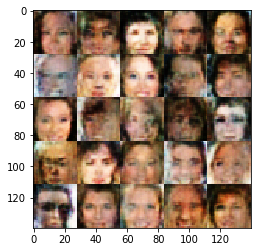

Epoch ... (1, 1)  Discriminator Loss:  1.31955  Generator Loss:  0.522425
Epoch ... (1, 1)  Discriminator Loss:  1.26402  Generator Loss:  0.461669
Epoch ... (1, 1)  Discriminator Loss:  1.27847  Generator Loss:  0.50383
Epoch ... (1, 1)  Discriminator Loss:  1.24688  Generator Loss:  0.541822
Epoch ... (1, 1)  Discriminator Loss:  1.26325  Generator Loss:  0.552571
Epoch ... (1, 1)  Discriminator Loss:  1.25702  Generator Loss:  0.612179
Epoch ... (1, 1)  Discriminator Loss:  1.23307  Generator Loss:  0.515902
Epoch ... (1, 1)  Discriminator Loss:  1.23851  Generator Loss:  0.530526
Epoch ... (1, 1)  Discriminator Loss:  1.21554  Generator Loss:  0.536841
Epoch ... (1, 1)  Discriminator Loss:  1.24038  Generator Loss:  0.588325
Training Value:  False
Tensor("generator_32/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


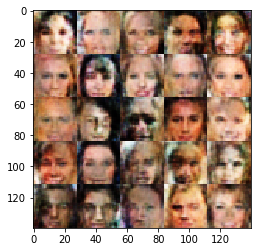

Epoch ... (1, 1)  Discriminator Loss:  1.22951  Generator Loss:  0.564371
Epoch ... (1, 1)  Discriminator Loss:  1.21469  Generator Loss:  0.539156
Epoch ... (1, 1)  Discriminator Loss:  1.28112  Generator Loss:  0.535871
Epoch ... (1, 1)  Discriminator Loss:  1.21759  Generator Loss:  0.64196
Epoch ... (1, 1)  Discriminator Loss:  1.22777  Generator Loss:  0.612027
Epoch ... (1, 1)  Discriminator Loss:  1.27202  Generator Loss:  0.542699
Epoch ... (1, 1)  Discriminator Loss:  1.26092  Generator Loss:  0.626268
Epoch ... (1, 1)  Discriminator Loss:  1.29465  Generator Loss:  0.53402
Epoch ... (1, 1)  Discriminator Loss:  1.23743  Generator Loss:  0.651495
Epoch ... (1, 1)  Discriminator Loss:  1.23369  Generator Loss:  0.520365
Training Value:  False
Tensor("generator_33/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


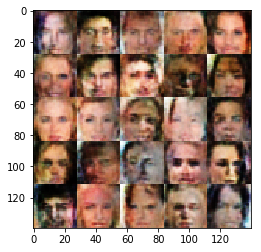

Epoch ... (1, 1)  Discriminator Loss:  1.22427  Generator Loss:  0.63192
Epoch ... (1, 1)  Discriminator Loss:  1.26741  Generator Loss:  0.539645
Epoch ... (1, 1)  Discriminator Loss:  1.21701  Generator Loss:  0.635247
Epoch ... (1, 1)  Discriminator Loss:  1.27834  Generator Loss:  0.57875
Epoch ... (1, 1)  Discriminator Loss:  1.25164  Generator Loss:  0.64577
Epoch ... (1, 1)  Discriminator Loss:  1.2514  Generator Loss:  0.55789
Epoch ... (1, 1)  Discriminator Loss:  1.29405  Generator Loss:  0.55157
Epoch ... (1, 1)  Discriminator Loss:  1.22984  Generator Loss:  0.547865
Epoch ... (1, 1)  Discriminator Loss:  1.27241  Generator Loss:  0.54554
Epoch ... (1, 1)  Discriminator Loss:  1.24456  Generator Loss:  0.543529
Training Value:  False
Tensor("generator_34/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


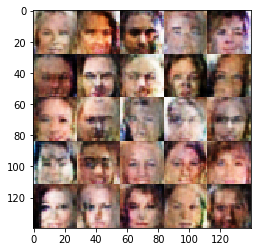

Epoch ... (1, 1)  Discriminator Loss:  1.26383  Generator Loss:  0.529353
Epoch ... (1, 1)  Discriminator Loss:  1.25842  Generator Loss:  0.555019
Epoch ... (1, 1)  Discriminator Loss:  1.27979  Generator Loss:  0.529758
Epoch ... (1, 1)  Discriminator Loss:  1.27739  Generator Loss:  0.519832
Epoch ... (1, 1)  Discriminator Loss:  1.22435  Generator Loss:  0.568939
Epoch ... (1, 1)  Discriminator Loss:  1.23512  Generator Loss:  0.538564
Epoch ... (1, 1)  Discriminator Loss:  1.22701  Generator Loss:  0.518048
Epoch ... (1, 1)  Discriminator Loss:  1.26327  Generator Loss:  0.607284
Epoch ... (1, 1)  Discriminator Loss:  1.26151  Generator Loss:  0.569566
Epoch ... (1, 1)  Discriminator Loss:  1.2253  Generator Loss:  0.520533
Training Value:  False
Tensor("generator_35/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


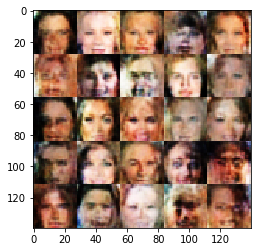

Epoch ... (1, 1)  Discriminator Loss:  1.2199  Generator Loss:  0.594029
Epoch ... (1, 1)  Discriminator Loss:  1.20717  Generator Loss:  0.547008
Epoch ... (1, 1)  Discriminator Loss:  1.21482  Generator Loss:  0.507932
Epoch ... (1, 1)  Discriminator Loss:  1.27527  Generator Loss:  0.524685
Epoch ... (1, 1)  Discriminator Loss:  1.25791  Generator Loss:  0.580069
Epoch ... (1, 1)  Discriminator Loss:  1.26572  Generator Loss:  0.605608
Epoch ... (1, 1)  Discriminator Loss:  1.28558  Generator Loss:  0.511061
Epoch ... (1, 1)  Discriminator Loss:  1.2573  Generator Loss:  0.560618
Epoch ... (1, 1)  Discriminator Loss:  1.26239  Generator Loss:  0.576175
Epoch ... (1, 1)  Discriminator Loss:  1.26937  Generator Loss:  0.594675
Training Value:  False
Tensor("generator_36/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


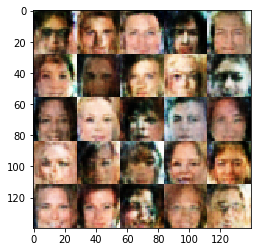

Epoch ... (1, 1)  Discriminator Loss:  1.28125  Generator Loss:  0.57821
Epoch ... (1, 1)  Discriminator Loss:  1.24543  Generator Loss:  0.52104
Epoch ... (1, 1)  Discriminator Loss:  1.27298  Generator Loss:  0.542095
Epoch ... (1, 1)  Discriminator Loss:  1.24484  Generator Loss:  0.583024
Epoch ... (1, 1)  Discriminator Loss:  1.30862  Generator Loss:  0.552385
Epoch ... (1, 1)  Discriminator Loss:  1.20996  Generator Loss:  0.513172
Epoch ... (1, 1)  Discriminator Loss:  1.24672  Generator Loss:  0.587217
Epoch ... (1, 1)  Discriminator Loss:  1.23208  Generator Loss:  0.575192
Epoch ... (1, 1)  Discriminator Loss:  1.22214  Generator Loss:  0.581987
Epoch ... (1, 1)  Discriminator Loss:  1.20401  Generator Loss:  0.566716
Training Value:  False
Tensor("generator_37/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


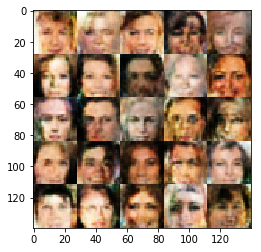

Epoch ... (1, 1)  Discriminator Loss:  1.26476  Generator Loss:  0.584204
Epoch ... (1, 1)  Discriminator Loss:  1.26668  Generator Loss:  0.534011
Epoch ... (1, 1)  Discriminator Loss:  1.25461  Generator Loss:  0.541032
Epoch ... (1, 1)  Discriminator Loss:  1.2543  Generator Loss:  0.579938
Epoch ... (1, 1)  Discriminator Loss:  1.24765  Generator Loss:  0.581468
Epoch ... (1, 1)  Discriminator Loss:  1.21875  Generator Loss:  0.650181
Epoch ... (1, 1)  Discriminator Loss:  1.2476  Generator Loss:  0.548706
Epoch ... (1, 1)  Discriminator Loss:  1.22229  Generator Loss:  0.598591
Epoch ... (1, 1)  Discriminator Loss:  1.22008  Generator Loss:  0.576171
Epoch ... (1, 1)  Discriminator Loss:  1.2654  Generator Loss:  0.569691
Training Value:  False
Tensor("generator_38/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


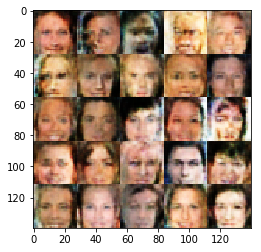

Epoch ... (1, 1)  Discriminator Loss:  1.26543  Generator Loss:  0.541926
Epoch ... (1, 1)  Discriminator Loss:  1.26444  Generator Loss:  0.544822
Epoch ... (1, 1)  Discriminator Loss:  1.25525  Generator Loss:  0.578514
Epoch ... (1, 1)  Discriminator Loss:  1.25405  Generator Loss:  0.63976
Epoch ... (1, 1)  Discriminator Loss:  1.23213  Generator Loss:  0.634936
Epoch ... (1, 1)  Discriminator Loss:  1.28563  Generator Loss:  0.558236
Epoch ... (1, 1)  Discriminator Loss:  1.22012  Generator Loss:  0.539149
Epoch ... (1, 1)  Discriminator Loss:  1.24752  Generator Loss:  0.604014
Epoch ... (1, 1)  Discriminator Loss:  1.24351  Generator Loss:  0.585289
Epoch ... (1, 1)  Discriminator Loss:  1.23639  Generator Loss:  0.541846
Training Value:  False
Tensor("generator_39/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


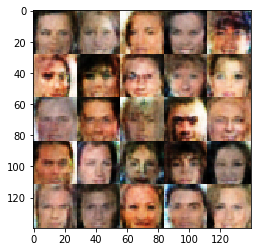

Epoch ... (1, 1)  Discriminator Loss:  1.21624  Generator Loss:  0.58298
Epoch ... (1, 1)  Discriminator Loss:  1.215  Generator Loss:  0.575723
Epoch ... (1, 1)  Discriminator Loss:  1.26212  Generator Loss:  0.564024
Epoch ... (1, 1)  Discriminator Loss:  1.25292  Generator Loss:  0.511317
Epoch ... (1, 1)  Discriminator Loss:  1.22427  Generator Loss:  0.565786
Epoch ... (1, 1)  Discriminator Loss:  1.23435  Generator Loss:  0.612741
Epoch ... (1, 1)  Discriminator Loss:  1.23332  Generator Loss:  0.528672
Epoch ... (1, 1)  Discriminator Loss:  1.27758  Generator Loss:  0.523383
Epoch ... (1, 1)  Discriminator Loss:  1.29492  Generator Loss:  0.507588
Epoch ... (1, 1)  Discriminator Loss:  1.24869  Generator Loss:  0.60691
Training Value:  False
Tensor("generator_40/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


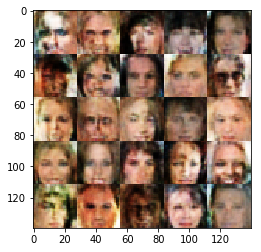

Epoch ... (1, 1)  Discriminator Loss:  1.28186  Generator Loss:  0.558936
Epoch ... (1, 1)  Discriminator Loss:  1.25444  Generator Loss:  0.541064
Epoch ... (1, 1)  Discriminator Loss:  1.24043  Generator Loss:  0.543801
Epoch ... (1, 1)  Discriminator Loss:  1.25595  Generator Loss:  0.622748
Epoch ... (1, 1)  Discriminator Loss:  1.25855  Generator Loss:  0.51914
Epoch ... (1, 1)  Discriminator Loss:  1.23509  Generator Loss:  0.5609
Epoch ... (1, 1)  Discriminator Loss:  1.22125  Generator Loss:  0.498637
Epoch ... (1, 1)  Discriminator Loss:  1.20483  Generator Loss:  0.491037
Epoch ... (1, 1)  Discriminator Loss:  1.24119  Generator Loss:  0.573225
Epoch ... (1, 1)  Discriminator Loss:  1.28018  Generator Loss:  0.541969
Training Value:  False
Tensor("generator_41/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


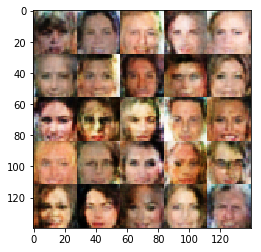

Epoch ... (1, 1)  Discriminator Loss:  1.24542  Generator Loss:  0.547575
Epoch ... (1, 1)  Discriminator Loss:  1.2057  Generator Loss:  0.557954
Epoch ... (1, 1)  Discriminator Loss:  1.2577  Generator Loss:  0.511067
Epoch ... (1, 1)  Discriminator Loss:  1.2494  Generator Loss:  0.492922
Epoch ... (1, 1)  Discriminator Loss:  1.2212  Generator Loss:  0.56605
Epoch ... (1, 1)  Discriminator Loss:  1.23473  Generator Loss:  0.651488
Epoch ... (1, 1)  Discriminator Loss:  1.25461  Generator Loss:  0.554927
Epoch ... (1, 1)  Discriminator Loss:  1.25648  Generator Loss:  0.529799
Epoch ... (1, 1)  Discriminator Loss:  1.23737  Generator Loss:  0.598183
Epoch ... (1, 1)  Discriminator Loss:  1.2198  Generator Loss:  0.493176
Training Value:  False
Tensor("generator_42/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


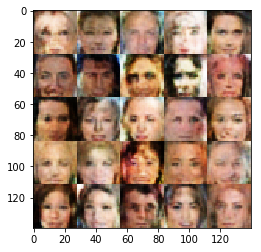

Epoch ... (1, 1)  Discriminator Loss:  1.25976  Generator Loss:  0.522057
Epoch ... (1, 1)  Discriminator Loss:  1.23591  Generator Loss:  0.600935
Epoch ... (1, 1)  Discriminator Loss:  1.20877  Generator Loss:  0.56529
Epoch ... (1, 1)  Discriminator Loss:  1.23099  Generator Loss:  0.511355
Epoch ... (1, 1)  Discriminator Loss:  1.25722  Generator Loss:  0.557321
Epoch ... (1, 1)  Discriminator Loss:  1.2458  Generator Loss:  0.599957
Epoch ... (1, 1)  Discriminator Loss:  1.25229  Generator Loss:  0.606246
Epoch ... (1, 1)  Discriminator Loss:  1.2824  Generator Loss:  0.556267
Epoch ... (1, 1)  Discriminator Loss:  1.22716  Generator Loss:  0.552027
Epoch ... (1, 1)  Discriminator Loss:  1.22326  Generator Loss:  0.663983
Training Value:  False
Tensor("generator_43/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


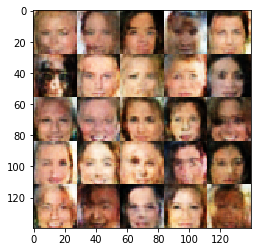

Epoch ... (1, 1)  Discriminator Loss:  1.18038  Generator Loss:  0.545122
Epoch ... (1, 1)  Discriminator Loss:  1.23642  Generator Loss:  0.58898
Epoch ... (1, 1)  Discriminator Loss:  1.20894  Generator Loss:  0.648837
Epoch ... (1, 1)  Discriminator Loss:  1.2376  Generator Loss:  0.615415
Epoch ... (1, 1)  Discriminator Loss:  1.2287  Generator Loss:  0.579201
Epoch ... (1, 1)  Discriminator Loss:  1.28929  Generator Loss:  0.530488
Epoch ... (1, 1)  Discriminator Loss:  1.22038  Generator Loss:  0.523309
Epoch ... (1, 1)  Discriminator Loss:  1.23574  Generator Loss:  0.562548
Epoch ... (1, 1)  Discriminator Loss:  1.18141  Generator Loss:  0.683344
Epoch ... (1, 1)  Discriminator Loss:  1.25243  Generator Loss:  0.518199
Training Value:  False
Tensor("generator_44/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


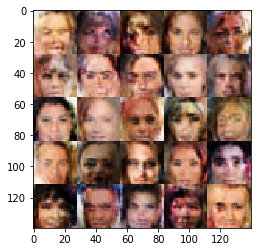

Epoch ... (1, 1)  Discriminator Loss:  1.26209  Generator Loss:  0.574514
Epoch ... (1, 1)  Discriminator Loss:  1.2718  Generator Loss:  0.659796
Epoch ... (1, 1)  Discriminator Loss:  1.25278  Generator Loss:  0.579656
Epoch ... (1, 1)  Discriminator Loss:  1.15262  Generator Loss:  0.642382
Epoch ... (1, 1)  Discriminator Loss:  1.22291  Generator Loss:  0.559863
Epoch ... (1, 1)  Discriminator Loss:  1.2892  Generator Loss:  0.469985
Epoch ... (1, 1)  Discriminator Loss:  1.21893  Generator Loss:  0.553833
Epoch ... (1, 1)  Discriminator Loss:  1.25027  Generator Loss:  0.57617
Epoch ... (1, 1)  Discriminator Loss:  1.26415  Generator Loss:  0.634263
Epoch ... (1, 1)  Discriminator Loss:  1.22634  Generator Loss:  0.643318
Training Value:  False
Tensor("generator_45/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


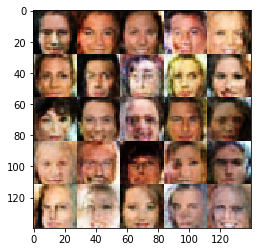

Epoch ... (1, 1)  Discriminator Loss:  1.23559  Generator Loss:  0.596696
Epoch ... (1, 1)  Discriminator Loss:  1.26646  Generator Loss:  0.565872
Epoch ... (1, 1)  Discriminator Loss:  1.23875  Generator Loss:  0.60425
Epoch ... (1, 1)  Discriminator Loss:  1.20327  Generator Loss:  0.618478
Epoch ... (1, 1)  Discriminator Loss:  1.23041  Generator Loss:  0.61036
Epoch ... (1, 1)  Discriminator Loss:  1.25354  Generator Loss:  0.575422
Epoch ... (1, 1)  Discriminator Loss:  1.25067  Generator Loss:  0.517337
Epoch ... (1, 1)  Discriminator Loss:  1.18253  Generator Loss:  0.559985
Epoch ... (1, 1)  Discriminator Loss:  1.29608  Generator Loss:  0.597234
Epoch ... (1, 1)  Discriminator Loss:  1.20089  Generator Loss:  0.629736
Training Value:  False
Tensor("generator_46/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


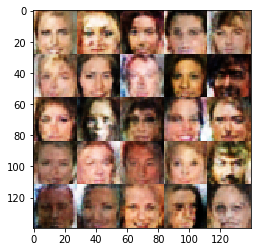

Epoch ... (1, 1)  Discriminator Loss:  1.27318  Generator Loss:  0.548156
Epoch ... (1, 1)  Discriminator Loss:  1.21391  Generator Loss:  0.545486
Epoch ... (1, 1)  Discriminator Loss:  1.23624  Generator Loss:  0.494779
Epoch ... (1, 1)  Discriminator Loss:  1.27192  Generator Loss:  0.60153
Epoch ... (1, 1)  Discriminator Loss:  1.23506  Generator Loss:  0.577296
Epoch ... (1, 1)  Discriminator Loss:  1.22941  Generator Loss:  0.590277
Epoch ... (1, 1)  Discriminator Loss:  1.21302  Generator Loss:  0.580654
Epoch ... (1, 1)  Discriminator Loss:  1.25153  Generator Loss:  0.543437
Epoch ... (1, 1)  Discriminator Loss:  1.23223  Generator Loss:  0.699445
Epoch ... (1, 1)  Discriminator Loss:  1.18898  Generator Loss:  0.625217
Training Value:  False
Tensor("generator_47/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


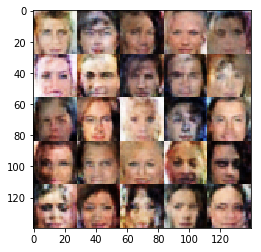

Epoch ... (1, 1)  Discriminator Loss:  1.22548  Generator Loss:  0.504107
Epoch ... (1, 1)  Discriminator Loss:  1.21564  Generator Loss:  0.638181
Epoch ... (1, 1)  Discriminator Loss:  1.2218  Generator Loss:  0.491951
Epoch ... (1, 1)  Discriminator Loss:  1.25221  Generator Loss:  0.548678
Epoch ... (1, 1)  Discriminator Loss:  1.25223  Generator Loss:  0.496422
Epoch ... (1, 1)  Discriminator Loss:  1.23995  Generator Loss:  0.526916
Epoch ... (1, 1)  Discriminator Loss:  1.18542  Generator Loss:  0.6495
Epoch ... (1, 1)  Discriminator Loss:  1.21605  Generator Loss:  0.613181
Epoch ... (1, 1)  Discriminator Loss:  1.28089  Generator Loss:  0.726389
Epoch ... (1, 1)  Discriminator Loss:  1.25324  Generator Loss:  0.578965
Training Value:  False
Tensor("generator_48/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


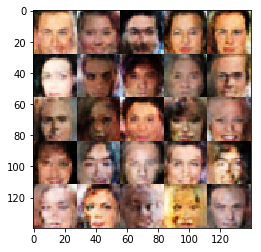

Epoch ... (1, 1)  Discriminator Loss:  1.19756  Generator Loss:  0.616142
Epoch ... (1, 1)  Discriminator Loss:  1.20453  Generator Loss:  0.55784
Epoch ... (1, 1)  Discriminator Loss:  1.2212  Generator Loss:  0.540307
Epoch ... (1, 1)  Discriminator Loss:  1.2314  Generator Loss:  0.565412
Epoch ... (1, 1)  Discriminator Loss:  1.17522  Generator Loss:  0.539048
Epoch ... (1, 1)  Discriminator Loss:  1.25514  Generator Loss:  0.524967
Epoch ... (1, 1)  Discriminator Loss:  1.26532  Generator Loss:  0.628949
Epoch ... (1, 1)  Discriminator Loss:  1.19372  Generator Loss:  0.629168
Epoch ... (1, 1)  Discriminator Loss:  1.22089  Generator Loss:  0.589719
Epoch ... (1, 1)  Discriminator Loss:  1.19936  Generator Loss:  0.541938
Training Value:  False
Tensor("generator_49/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


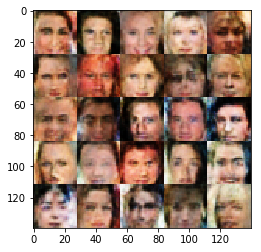

Epoch ... (1, 1)  Discriminator Loss:  1.2286  Generator Loss:  0.615118
Epoch ... (1, 1)  Discriminator Loss:  1.15501  Generator Loss:  0.599507
Epoch ... (1, 1)  Discriminator Loss:  1.23725  Generator Loss:  0.481807
Epoch ... (1, 1)  Discriminator Loss:  1.21835  Generator Loss:  0.659237
Epoch ... (1, 1)  Discriminator Loss:  1.19033  Generator Loss:  0.568615
Epoch ... (1, 1)  Discriminator Loss:  1.20462  Generator Loss:  0.567961
Epoch ... (1, 1)  Discriminator Loss:  1.29231  Generator Loss:  0.576228
Epoch ... (1, 1)  Discriminator Loss:  1.24375  Generator Loss:  0.605195
Epoch ... (1, 1)  Discriminator Loss:  1.21476  Generator Loss:  0.524456
Epoch ... (1, 1)  Discriminator Loss:  1.236  Generator Loss:  0.537189
Training Value:  False
Tensor("generator_50/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)


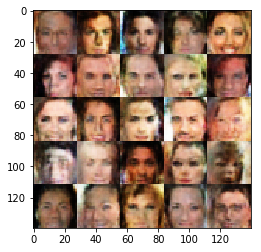

Epoch ... (1, 1)  Discriminator Loss:  1.16758  Generator Loss:  0.63102
Epoch ... (1, 1)  Discriminator Loss:  1.25436  Generator Loss:  0.604734
Epoch ... (1, 1)  Discriminator Loss:  1.2344  Generator Loss:  0.57821
Epoch ... (1, 1)  Discriminator Loss:  1.21965  Generator Loss:  0.588282
Epoch ... (1, 1)  Discriminator Loss:  1.21637  Generator Loss:  0.587971
Epoch ... (1, 1)  Discriminator Loss:  1.21789  Generator Loss:  0.520483


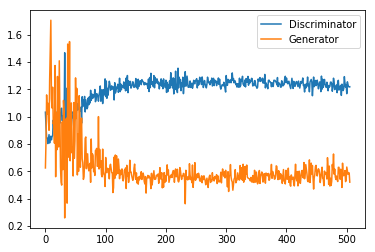

In [17]:
batch_size = 40
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.